# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Training language model (Many-to-Many) and generating sequences (One-to-Many)

**Author: geoffroy.peeters@telecom-paris.fr**

**Version**:
- 2022/06/15 (changed to tensorfow.keras, added translation of questions in EN)
- 2022/10/03 (added ReLU, np_epoch=20)

For any remark or suggestion, please feel free to contact me.


## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime).

- We will first train a language model on the whole set of MIDI files of the "Cello suites".
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

### Questions:

In the bottom part of this lab, you will have to answer a set of questions. Answers to those only necessitates a couple of sentences.

## Import packages

In [1]:
! pip install pretty_midi

import os
import pretty_midi
from scipy.io import wavfile
import IPython

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation

import matplotlib.pyplot as plt
import numpy as np
import glob

student = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.2 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=4afc1539e8bc8d4fdb30682265dcc66bd09cf9a80e9b730680273a998b0c8c5d
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


# Get the data

In [2]:
n_x = 79
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [3]:
DIR = './'
import urllib.request
midiFile_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midiFile in midiFile_l:
  #if os.path.isfile(DIR + midiFile) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midiFile, DIR + midiFile)
nbExample = len(midiFile_l)

midiFile_l = glob.glob(DIR + 'cs*.mid')
print(midiFile_l)

['./cs6-1pre.mid', './cs3-6gig.mid', './cs3-4sar.mid', './cs5-4sar.mid', './cs6-2all.mid', './cs2-2all.mid', './cs4-5bou.mid', './cs4-3cou.mid', './cs4-4sar.mid', './cs2-6gig.mid', './cs4-2all.mid', './cs3-2all.mid', './cs5-5gav.mid', './cs5-3cou.mid', './cs2-3cou.mid', './cs3-1pre.mid', './cs1-4sar.mid', './cs3-3cou.mid', './cs4-1pre.mid', './cs6-5gav.mid', './cs2-1pre.mid', './cs1-5men.mid', './cs2-4sar.mid', './cs1-6gig.mid', './cs6-4sar.mid', './cs5-1pre.mid', './cs1-3cou.mid', './cs6-6gig.mid', './cs2-5men.mid', './cs3-5bou.mid', './cs5-2all.mid', './cs6-3cou.mid', './cs1-1pre.mid', './cs4-6gig.mid', './cs5-6gig.mid', './cs1-2all.mid']


## Read and convert all MIDI files

In [4]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midiFile_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 50, start: 0.000000, end: 0.230769, duration: 0.230769
pitch: 50, start: 0.461538, end: 0.692307, duration: 0.230769
pitch: 50, start: 0.692307, end: 0.923076, duration: 0.230769
pitch: 54, start: 1.153845, end: 1.384614, duration: 0.230769
pitch: 50, start: 1.384614, end: 1.615383, duration: 0.230769
pitch: 57, start: 1.846152, end: 2.076921, duration: 0.230769
pitch: 50, start: 2.076921, end: 2.307690, duration: 0.230769
pitch: 62, start: 2.538459, end: 2.769228, duration: 0.230769
pitch: 50, start: 2.769228, end: 2.999997, duration: 0.230769
pitch: 50, start: 3.230766, end: 3.461535, duration: 0.230769
pitch: 50, start: 3.461535, end: 3.692304, duration: 0.230769
pitch: 54, start: 3.923073, end: 4.153842, duration: 0.230769
pitch: 50, start: 4.153842, end: 4.384611, duration: 0.230769
pitch: 57, start: 4.615380, end: 4.846149, duration: 0.230769
pitch: 50, start: 4.846149, end: 5.076918, duration: 0.230769
pitch: 62, start: 5.307687, end: 5.538456, duration: 0.230769
pitch: 5

We read all MIDI files and convert their content to one-hot-encoding matrix X_ohe of dimensions (T_x, n_x) where n_x is the number of possible musical notes.
The duration of the sequences T_x can vary from one sequence to the other.



In [5]:
# --- We truncate the duration of each example to the first T_x data

X_list = []

for midiFile in midiFile_l:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    # convert to one-hot-encoding
    T_x = len(note_l)
    if T_x > max_T_x:
        T_x = max_T_x
    X_ohe = np.zeros((T_x, n_x))
    for t in range(T_x):
        X_ohe[t, note_l[t]-1] = 1
    # add to the list
    X_list.append(X_ohe)

print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(1000, 79)
(644, 79)
(196, 79)


## Display the set of notes over time for a specific track

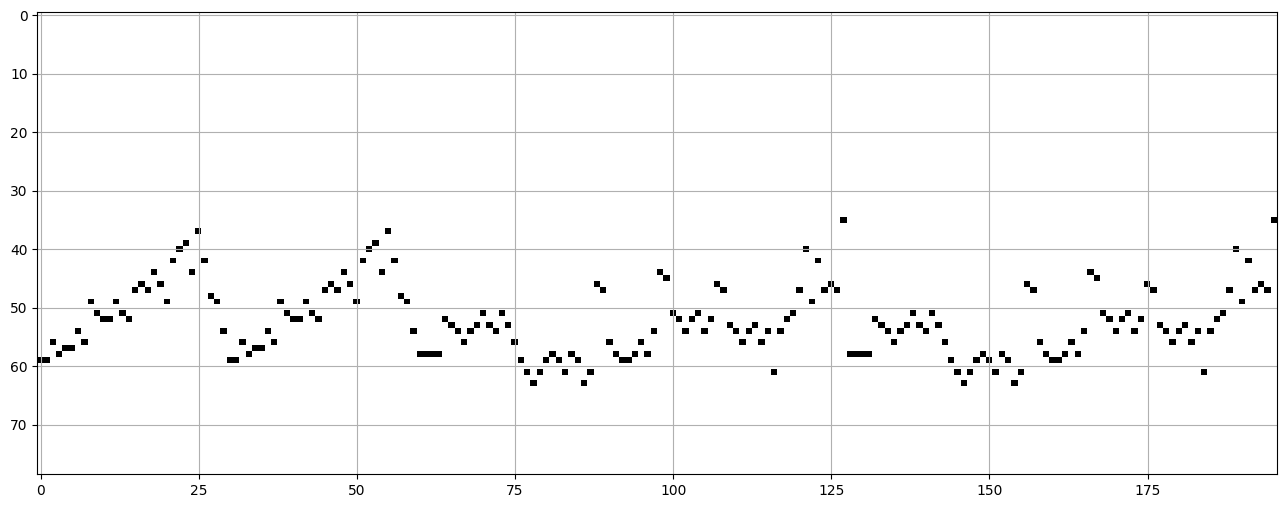

In [6]:
plt.figure(figsize=(16, 6))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

For each example/sequence and each possible starting note in this example/sequence, we create two sequences
- an input sequence:
  - which contains a sub-sequence of length ```sequence_length```;  this sub-sequence range from the note $t$ to the note $t+sequence\_length-1$
- an output sequence:
  - which contains the following note to be predicted, the one at position $t+sequence\_length$

The training is therefore performed by giving to the model a set of sequences as input and asking the network to predict each time the note that should come right after this sequence.

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_02.png">


In [7]:
X_train_list = []
y_train_list = []

if student:
    # --- START CODE HERE (01)
    for x_list in X_list:
      for t in range(0, len(x_list)-sequence_length-1):
        X_train_list.append(x_list[t:t+sequence_length])
        y_train_list.append(x_list[t+sequence_length])
    # --- END CODE HERE

X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (23745, 20, 79)
y_train.shape: (23745, 79)


# Training the language model

The language model will be learned by training an RNN with input `X_train` and output `Y_train`:  for each of the examples of sequences, we give to the network a sequence of notes of `sequence_length` duration, and ask the network to predict the following note of each sequence.

The network will have the following structure
- (1a) a layer of `LSTM` with $n_a$=256
- (1b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (2a) a layer of `LSTM` with $n_a$=256
- (2b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (3) a layer of `LSTM` with $n_a$=256
- (4a) a layer of `Dense` with 256 units and a `ReLU` activation
- (4b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (5) a layer of `Dense` with a `softmax` activation which predict the probability of each of the $n_x$ notes as output

## Returning the hidden states at each time of an LSTM cell

Note that when we stack one LSTM layer on top of a second LSTM layer (deep-RNN), we need to tell the first LSTM to output its hidden states at each time $t$. This is done by the option `return_sequences=True` that has to be given as parameter to the LSTM on top of the other one.
This is the case for (1a) and (2a).

However, since we are only interrested in the last hidden state of the third LSTM (since we are only interrest in its prediction at time $T_x$), we give the option `return_sequences=False` (which is the default behaviour) for the third LSTM.
This is the case for (3).

In [8]:
# --- Create the model
K.clear_session()

if student:
    # --- START CODE HERE (02)
    model = Sequential()
    model.add(Input(shape=(sequence_length, n_x)))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(256))
    model.add(Dense(256, activation='ReLU'))
    model.add(Dropout(0.3))
    model.add(Dense(n_x, activation='softmax'))
    # --- END CODE HERE

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 256)           344064    
                                                                 
 dropout (Dropout)           (None, 20, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 20, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [9]:
# --- Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
372/372 [==============================] - 17s 11ms/step - loss: 3.0169 - accuracy: 0.1062
Epoch 2/20
372/372 [==============================] - 3s 9ms/step - loss: 2.6938 - accuracy: 0.1493
Epoch 3/20
372/372 [==============================] - 3s 9ms/step - loss: 2.5742 - accuracy: 0.1690
Epoch 4/20
372/372 [==============================] - 4s 10ms/step - loss: 2.5118 - accuracy: 0.1891
Epoch 5/20
372/372 [==============================] - 3s 9ms/step - loss: 2.4616 - accuracy: 0.2214
Epoch 6/20
372/372 [==============================] - 3s 9ms/step - loss: 2.4039 - accuracy: 0.2576
Epoch 7/20
372/372 [==============================] - 3s 9ms/step - loss: 2.3477 - accuracy: 0.2812
Epoch 8/20
372/372 [==============================] - 4s 10ms/step - loss: 2.2988 - accuracy: 0.2995
Epoch 9/20
372/372 [==============================] - 3s 9ms/step - loss: 2.2430 - accuracy: 0.3175
Epoch 10/20
372/372 [==============================] - 3s 9ms/step - loss: 2.1847 - accuracy: 0.

# Generating a new sequence from sampling the language model

To generate a new sequence from the language model, we simply give it as input a random sequence of duration ```sequence_length```and ask the trained network to predict the output (using ```model.predict```).

The output of the network is a vector of probability of dimension $n_x$ which represents the probability of each note to be the next note of the melody given as input.

From this vector, we select the note which has the maximum probability.

We then concatenate this new note (its one-hot-encoding representation) at the end of the input sequence.
We finally remove the first element of the input sequence to keep its duration constant (```sequence_length```).

Instead of providing a random sequence as input, we rather randomly select one sequence out of the 23.781 sequences used for training.

- The ```pattern``` variable is the ```list``` of init notes to which we progressively append the new generated notes by the model.
- The ```prediction``` variable is a ```list``` which stores the softmax probability vector (a numpy array) corresponding to each generation time.


In [32]:
# --- Select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train_list[start]
print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)

3988
(20, 79)
(1, 20, 79)


In [33]:
# --- note_l: is the list of notes (integer number) over time
note_l = []
# --- prediction_l: is the list of output-vectors (float numbers \in [0,1]) of the network over time
prediction_l = []
# --- Generate T_y_generated notes
for note_index in range(T_y_generated):
    if student:
        # --- START CODE HERE (03)
        prediction = model.predict(np.expand_dims(pattern, 0))
        prediction_l.append(prediction)
        note_pred = prediction.argmax()
        note_hot = np.zeros((1, 79))
        note_hot[0, note_pred] = 1
        note_l.append(note_pred)
        pattern = np.concatenate([pattern, note_hot] ,axis=0)
        # --- END CODE HERE

1/1 [==============================] - 0s 44ms/step


### Display the generated sequence

[52, 54, 55, 54, 52, 54, 50, 49, 50, 52, 54, 55, 57, 54, 55, 54, 52, 54, 50, 49, 50, 52, 54, 55, 57, 54, 55, 54, 52, 54, 50, 51, 52, 50, 49, 47, 45, 47, 49, 50, 52, 50, 52, 54, 55, 52, 54, 52, 50, 49, 47, 45, 43, 42, 50, 43, 50, 42, 40, 43, 49, 50, 49, 50, 43, 43, 45, 47, 49, 40, 57, 55, 54, 52, 50, 45, 43, 42, 43, 40, 40, 47, 49, 50, 52, 54, 55, 54, 52, 50, 49, 50, 52, 54, 55, 54, 52, 54, 50, 49, 50, 52, 54, 55, 57, 54, 55, 57, 59, 60, 59, 57, 59, 55, 57, 59, 57, 55, 57, 62, 59, 62, 61, 62, 61, 62, 61, 59, 57, 55, 54, 52, 50, 53, 56, 59, 59, 61, 54, 52, 50, 50, 52, 49, 50, 49, 47, 46, 47, 49, 50, 52, 54, 49, 47, 46, 47, 50, 49, 47, 46, 47, 50, 49, 47, 46, 47, 50, 52, 54, 55, 52, 49, 54, 50, 42, 50, 52, 50, 49, 47, 46, 47, 49, 47, 46, 47, 46, 47, 54, 52, 54, 55, 54, 52, 54, 52, 50, 49, 50]


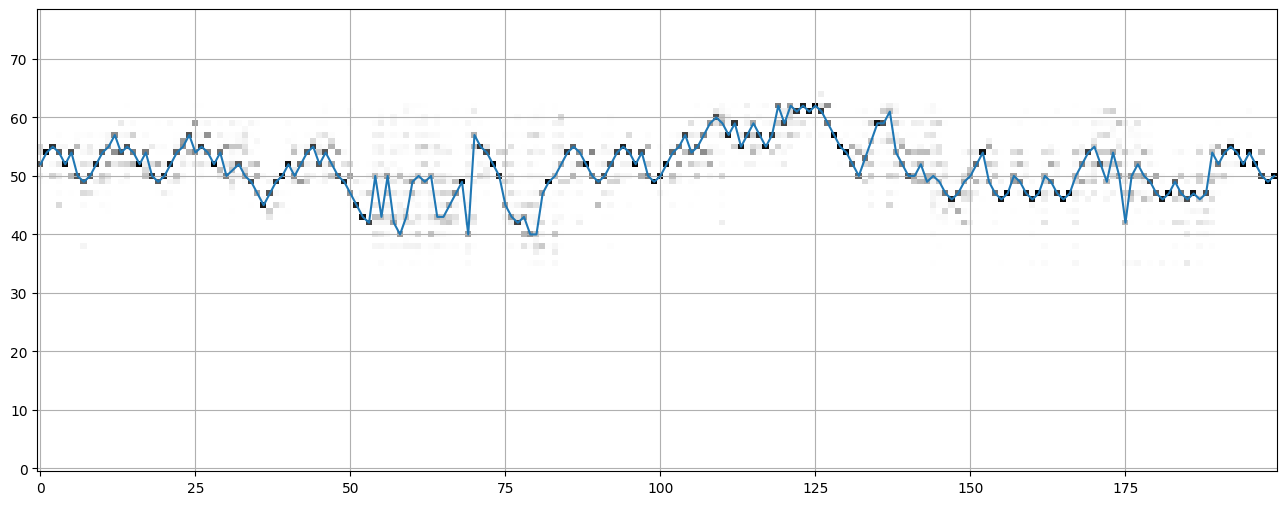

In [34]:
print(note_l)

plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:,0,:].T, aspect='auto', origin='lower')
plt.plot(note_l)
plt.set_cmap('gray_r')
plt.grid(True)

### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [35]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)
new_midi_data.write('output.mid')

In [36]:
%matplotlib inline

audio_data = new_midi_data.synthesize(fs=44100)
IPython.display.Audio(audio_data, rate=44100)

# Evaluation

To evaluate the work, you should rate the code for
- 1) Data conversion for the training of language model (01)
- 2) Training the language model (02)
- 3) Generating a new sequence from sampling the language model (03)

You will also rate the answer to the four questions below.

## Question 1)

What happens if we replace the LSTM cell by a RNNsimple cell?

**Answer below** (1 points)

Answer: If we replace by a simple RNN cell, then it will be faster to compute. However, it has a short memory term so it could not capture long term patterns in the sequence (only a few notes before it). Indeed, the simple RNN cell struggles with the problem of gradient vanishing along the time.

## Question 2)

What happens if we shorten the length of the sequences used for training? How can this effect be avoided?

**Answer below** (1 points)

Answer: If we shorten the length of the sequences then we lost a bit of the training of long term patterns, however the training should be faster to train. I think we would lose some complexity of the generated music.

## Question 3)

How could we make the system polyphonic (several notes played simultaneously by the same instrument)? for training? for generation?

**Answer below** (2 points)

Answer: For the training we could use a multi-hot encoding. For example, if we play the notes 54 and 23 simultaneously then we put a zero-vector with one at the 23th and 54th positions. For the generation, we couldn't just take the maximum of the probability. However, we have always the probability that each note is right to play. We can sample uniformly between 0 and 1 and take notes until a note is sampled twice. For example if we have 0.3 for note1, 0.6 for note2 and 0.1 for note3, we sample randomly a number between 0 and 1. Let's imagine it's 0.5, then we take note2, and we sample again and it's 0.1 then we also take note1, and we sample again and it's 0.6 so it's note2. However it's already chosen so we stop the generation for this time.

## Question 4)

We used a simplified procedure to train the musical language model, transforming the learning into a Many-To-one problem. Explain ? How does one usually train a language model with an RNN? What would be the advantage?

**Answer below** (2 points)

Answer: It's many to one because for the input we take a sequence of notes and the output is the next note.